# Passer Ratings: Physical attributes 🤙 💪 🧍

Hypothesis: Hand size/height/arm length affects average career passer rating.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sys
import pickle
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
# import pymc3 as pm
sys.path.append('..')

In [2]:
df = pd.read_csv('../data/passer_ratings.csv', index_col=0)
df['attempts'] = round(df['attempts']/100)
df['sack_rate'] = round(df['sack_rate']*100,2)
df['alt_rate'] = round(df['alt_rate']*100,2)
df['precip_rate'] = round(df['precip_rate']*100,2)
df['turf_rate'] = round(df['turf_rate']*100,2)
df['away_rate'] = round(df['away_rate']*100,2)
df['temp'] = round(df['temp'])
df.drop(['alt_rate', 'wind_rate', 'turf_rate'], axis=1, inplace=True)
df

,year,attempts,avg_rating,sack_rate,precip_rate,away_rate,temp,height,arm,hand,dpos,seasons
DB-3800-2011,2011,8.0,110.6,3.65,0.00,50.00,69.0,72.0,31.250,10.00,32,11
PM-0200-2013,2013,8.0,111.7,2.23,5.26,42.11,58.0,77.0,31.500,10.13,1,16
EM-0200-2011,2011,8.0,95.1,4.93,10.00,55.00,58.0,77.0,30.750,9.75,1,8
TB-2300-2011,2011,7.0,104.8,4.62,0.00,42.11,55.0,76.0,32.750,9.38,199,12
MR-2500-2016,2016,6.0,119.9,6.61,5.26,42.11,69.0,77.0,32.375,9.50,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...
TD-1400-2007,2007,2.0,55.1,10.93,0.00,42.86,60.0,76.0,32.250,9.63,6,14
MM-2800-2005,2005,2.0,55.2,8.41,11.11,33.33,56.0,74.0,32.000,9.75,149,5
JS-3700-2012,2012,2.0,55.4,6.94,14.29,57.14,64.0,77.0,32.000,9.75,285,3
SM-2400-2007,2007,2.0,73.9,4.63,16.67,66.67,66.0,74.0,32.250,10.50,3,13


In [3]:
def var_plot(data, var, cuts=3, func=pd.cut, **kwargs):
    print(data[var].mean(), data[var].median(), data[var].mode())
    data[var].hist()
    plt.axvline(data[var].mean(), color='k', linestyle='dashed', linewidth=1)
    
    out, bins = func(data[var], cuts, retbins=True, **kwargs)
    print(out)
    print(out.value_counts())
    for bin_ in bins:
        plt.axvline(bin_, color='r', linestyle='dashed', linewidth=2)
    return out, bins

6.586885245901639 6.0 0    2
dtype: int64
DB-3800-2011    2
PM-0200-2013    2
EM-0200-2011    1
TB-2300-2011    2
MR-2500-2016    2
               ..
TD-1400-2007    2
MM-2800-2005    1
JS-3700-2012    0
SM-2400-2007    2
JG-1850-2016    0
Name: seasons, Length: 610, dtype: int64
0    243
1    184
2    183
Name: seasons, dtype: int64


(DB-3800-2011    2
 PM-0200-2013    2
 EM-0200-2011    1
 TB-2300-2011    2
 MR-2500-2016    2
                ..
 TD-1400-2007    2
 MM-2800-2005    1
 JS-3700-2012    0
 SM-2400-2007    2
 JG-1850-2016    0
 Name: seasons, Length: 610, dtype: int64,
 array([ 1.,  4.,  8., 20.]))

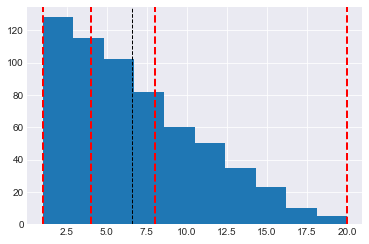

In [4]:
var_plot(df, 'seasons', cuts=3, func=pd.qcut, duplicates='raise', labels=False)

## Variable of Interest

We dont HAVE to only use extreme values, but you may wish to.

Height and arm length are postively correlated (0.45), so it's a little difficult to control for one when investigating the other. Height is of bigger interest than arm, and we suspect it is a bigger influence. However we see the drawback in not controlling for this. 

In [5]:
df_exp = df.copy()

In [6]:
T = 'hand' # the name of the treatment variable
drop = []

# specifically for height study
# df_exp.drop('arm', axis=1, inplace=True)

9.673183606557377 9.63 0    9.5
dtype: float64
DB-3800-2011    2
PM-0200-2013    2
EM-0200-2011    1
TB-2300-2011    0
MR-2500-2016    1
               ..
TD-1400-2007    1
MM-2800-2005    1
JS-3700-2012    1
SM-2400-2007    2
JG-1850-2016    0
Name: hand, Length: 610, dtype: int64
1    224
0    204
2    182
Name: hand, dtype: int64


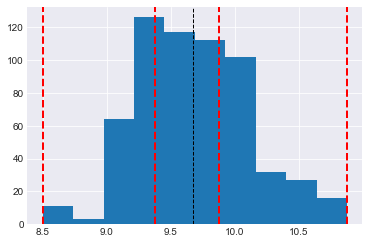

In [7]:
# if continuous treatment where should we cut it
cuts = 3
out, _ = var_plot(df_exp, T, cuts=cuts, func=pd.qcut, duplicates='raise', labels=False)

In [8]:
df_exp = df_exp.loc[(out==cuts-1) | (out==0), :] # only extreme values because trying for stata with all levels is very tough
df_exp[T].value_counts()
new_cuts = 2
replace = {T: {'bins':new_cuts, 'cut': 'qcut'}} # note if we remove centre chunk the regression is invalid for those values, right?

9.676637305699481 9.38 0    10.0
dtype: float64
DB-3800-2011    (9.38, 10.875]
PM-0200-2013    (9.38, 10.875]
TB-2300-2011     (8.499, 9.38]
DB-3800-2013    (9.38, 10.875]
TB-2300-2017     (8.499, 9.38]
                     ...      
BC-2800-2007    (9.38, 10.875]
KC-2000-2009    (9.38, 10.875]
MB-4500-2004     (8.499, 9.38]
SM-2400-2007    (9.38, 10.875]
JG-1850-2016     (8.499, 9.38]
Name: hand, Length: 386, dtype: category
Categories (2, interval[float64]): [(8.499, 9.38] < (9.38, 10.875]]
(8.499, 9.38]     204
(9.38, 10.875]    182
Name: hand, dtype: int64


,year,attempts,avg_rating,sack_rate,precip_rate,away_rate,temp,height,arm,hand,dpos,seasons
DB-3800-2011,2011,8.0,110.6,3.65,0.00,50.00,69.0,72.0,31.25,10.00,32,11
PM-0200-2013,2013,8.0,111.7,2.23,5.26,42.11,58.0,77.0,31.50,10.13,1,16
TB-2300-2011,2011,7.0,104.8,4.62,0.00,42.11,55.0,76.0,32.75,9.38,199,12
DB-3800-2013,2013,7.0,102.3,5.24,11.11,55.56,63.0,72.0,31.25,10.00,32,13
TB-2300-2017,2017,7.0,103.9,5.12,5.26,42.11,55.0,76.0,32.75,9.38,199,18
...,...,...,...,...,...,...,...,...,...,...,...,...
BC-2800-2007,2007,2.0,69.9,6.64,0.00,55.56,54.0,74.0,31.13,9.88,85,2
KC-2000-2009,2009,2.0,65.5,2.24,42.86,57.14,63.0,77.0,32.75,10.00,1,15
MB-4500-2004,2004,2.0,63.9,5.93,0.00,44.44,64.0,73.0,32.25,9.13,118,12
SM-2400-2007,2007,2.0,73.9,4.63,16.67,66.67,66.0,74.0,32.25,10.50,3,13


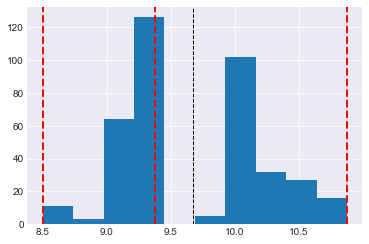

In [9]:
var_plot(df_exp, T, cuts=new_cuts, func=pd.qcut, duplicates='raise', labels=None)
df_exp

## One-to-many CEM with weighted linear regression
## k-k CEM with linear regression
## One-to-many CEM with weighted t-test / z-test
## k-k CEM with t-test / z-test
## One-to-many with Bayesian difference of means (May not be possible with beta-binomial conjugacy)
## k-k CEM with Bayesian difference of means

## Matching

### Coarsened Exact Matching

In [12]:
df_exp

,year,attempts,avg_rating,sack_rate,precip_rate,away_rate,temp,height,arm,hand,dpos,seasons
DB-3800-2011,2011,8.0,110.6,3.65,0.00,50.00,69.0,72.0,31.25,10.00,32,11
PM-0200-2013,2013,8.0,111.7,2.23,5.26,42.11,58.0,77.0,31.50,10.13,1,16
TB-2300-2011,2011,7.0,104.8,4.62,0.00,42.11,55.0,76.0,32.75,9.38,199,12
DB-3800-2013,2013,7.0,102.3,5.24,11.11,55.56,63.0,72.0,31.25,10.00,32,13
TB-2300-2017,2017,7.0,103.9,5.12,5.26,42.11,55.0,76.0,32.75,9.38,199,18
...,...,...,...,...,...,...,...,...,...,...,...,...
BC-2800-2007,2007,2.0,69.9,6.64,0.00,55.56,54.0,74.0,31.13,9.88,85,2
KC-2000-2009,2009,2.0,65.5,2.24,42.86,57.14,63.0,77.0,32.75,10.00,1,15
MB-4500-2004,2004,2.0,63.9,5.93,0.00,44.44,64.0,73.0,32.25,9.13,118,12
SM-2400-2007,2007,2.0,73.9,4.63,16.67,66.67,66.0,74.0,32.25,10.50,3,13


In [10]:
from matching.cem import CEM

In [13]:
continuous = df_exp.drop(T, axis=1).columns.values
cem = CEM(df_exp, T, 'avg_rating', continuous, H=5)

Unable to allocate 2.10 GiB for an array with shape (7, 7, 7, 7, 7, 7, 7, 7, 7, 7) and data type float64


In [41]:
cem.__dict__

{'data':               year  attempts  avg_rating  sack_rate  precip_rate  away_rate  \
 DB-3800-2011  2011       8.0       110.6       3.65         0.00      50.00   
 PM-0200-2013  2013       8.0       111.7       2.23         5.26      42.11   
 TB-2300-2011  2011       7.0       104.8       4.62         0.00      42.11   
 DB-3800-2013  2013       7.0       102.3       5.24        11.11      55.56   
 TB-2300-2017  2017       7.0       103.9       5.12         5.26      42.11   
 ...            ...       ...         ...        ...          ...        ...   
 BC-2800-2007  2007       2.0        69.9       6.64         0.00      55.56   
 KC-2000-2009  2009       2.0        65.5       2.24        42.86      57.14   
 MB-4500-2004  2004       2.0        63.9       5.93         0.00      44.44   
 SM-2400-2007  2007       2.0        73.9       4.63        16.67      66.67   
 JG-1850-2016  2016       2.0        63.6      11.26        14.29      42.86   
 
               temp  height   

In [34]:
coarsening = {
    'year': {'bins': 3, 'cut': 'cut'},
    'attempts': {'bins': 3, 'cut': 'cut'},
    'sack_rate': {'bins': 3, 'cut': 'qcut'},
    'precip_rate': {'bins': 3, 'cut': 'cut'},
    'away_rate': {'bins': 2, 'cut': 'qcut'},
    'temp': {'bins': 2, 'cut': 'qcut'},
    'height': {'bins': 2, 'cut': 'cut'},
    'arm': {'bins': 2, 'cut': 'qcut'},
    'hand': {'bins': 2, 'cut': 'qcut'},
    'dpos': {'bins': 2, 'cut': 'qcut'},
    'seasons': {'bins': 2, 'cut': 'qcut'},
}
coarsening.update(replace)
coarsening

{'year': {'bins': 3, 'cut': 'cut'},
 'attempts': {'bins': 3, 'cut': 'cut'},
 'sack_rate': {'bins': 3, 'cut': 'qcut'},
 'precip_rate': {'bins': 3, 'cut': 'cut'},
 'away_rate': {'bins': 2, 'cut': 'qcut'},
 'temp': {'bins': 2, 'cut': 'qcut'},
 'height': {'bins': 2, 'cut': 'cut'},
 'arm': {'bins': 2, 'cut': 'qcut'},
 'hand': {'bins': 2, 'cut': 'qcut'},
 'dpos': {'bins': 2, 'cut': 'qcut'},
 'seasons': {'bins': 2, 'cut': 'qcut'}}

In [35]:
#model
relax_on = [('year', range(4,11), 'cut')]
# formula = 'good ~ ' + ' + '.join(df_exp.drop(['good']+drop, axis=1).columns)
formula = f'avg_rating ~ {T}'
regressed, relaxed = cem.regress(coarsening, relax_on, formula=formula, drop=drop, include_relax=True)

0%|          | 0/7 [00:00<?, ?it/s]Regressing with 7 different pd.cut binnings on "year"

100%|██████████| 7/7 [01:22<00:00, 11.75s/it]


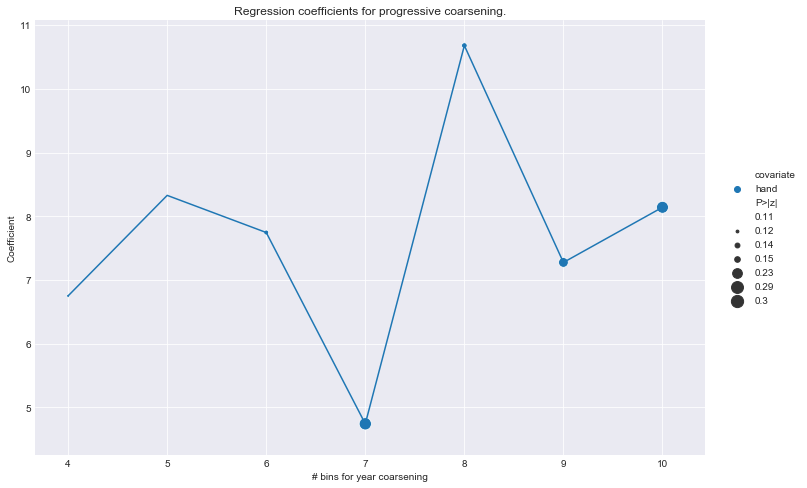

In [36]:
regressed.plot(include=[T], stars=True, legend='full')

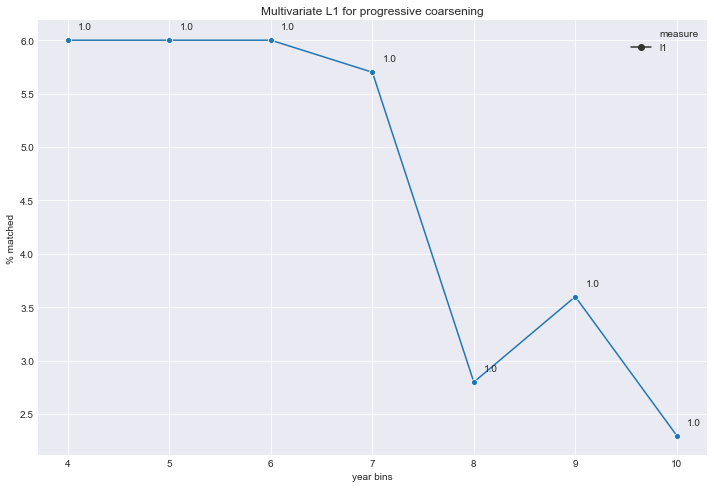

In [37]:
_ = relaxed.plot('multivariate')

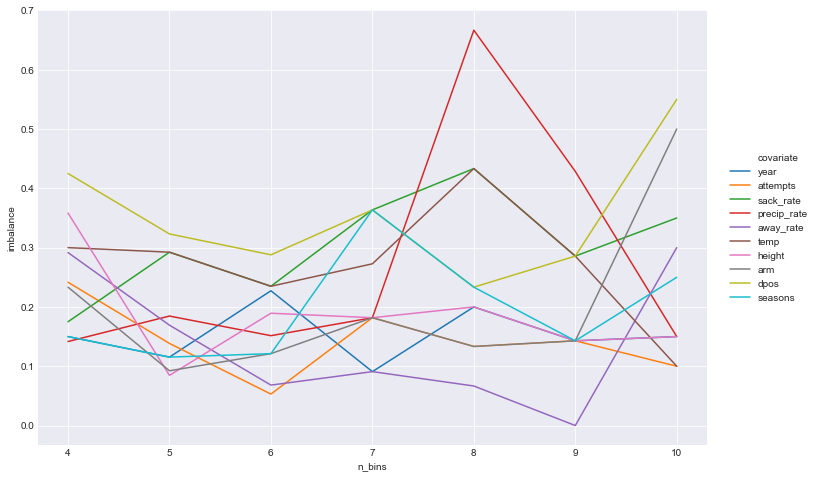

In [38]:
relaxed.plot('univariate')

## Model -- If you want to use BEST you'll need to find a way to included weights or use a 1:1 exact matching

We'll use the BEST method for comparing means of the two groups.

In [ ]:
dd = pd.concat((cem.data, cem.weights.rename('weights')), axis=1)
dd = dd.loc[dd['weights']>0, :]
treatment = dd.loc[dd[on], 'avg_rating']
control = dd.loc[~dd[on], 'avg_rating']
weights = dd['weights']

In [ ]:
f, axes = plt.subplots(1,2, sharey=True, sharex=True)
sns.distplot(treatment, ax=axes[0])
axes[0].set_title(f'Passer rating - {on}')
sns.distplot(control, ax=axes[1])
axes[1].set_title(f'Passer rating - not {on}')
plt.show()

Because of the relatively small sample sizes we assume our distributions are of the students-t distribution (Kruschke).
The students-t has a mean, variance, and degree-of-freedom.
The degree of freedom control the normality of the data (larger dof converges to normal distribution).

Lets set up the model

In [ ]:
# priors on the mean
m_mu = pd.concat([control,treatment]).mean()
m_sd = pd.concat([control,treatment]).std()

with pm.Model() as model:
    treatment_mean = pm.Normal('treatment_mean', mu=m_mu, sd=m_sd)
    control_mean = pm.Normal('control_mean', mu=m_mu, sd=m_sd)

In [ ]:
# priors on the standard deviation
sd_low = 1
sd_high = 30

with model:
    treatment_std = pm.Uniform('treatment_std', lower=sd_low, upper=sd_high)
    control_std = pm.Uniform('control_std', lower=sd_low, upper=sd_high)

In [ ]:
# shared prior on the degree of freedom parameter
with model:
    v = pm.Exponential('v_minus_one', 1/29.) + 1

In [ ]:
# pymc3 paramaterises students t with precision, rather than standard deviation (lambda = 1/sigma^2)
with model:
    treatment_lambda = treatment_std**-2  # deterministic
    control_lambda = control_std**-2 # deterministic

    treatment_rating = pm.StudentT(f'{on}', nu=v, mu=treatment_mean, lam=treatment_lambda, observed=treatment)
    control_rating = pm.StudentT(f'not {on}', nu=v, mu=control_mean, lam=control_lambda, observed=control)

In [ ]:
with model:
    # our deterministic values, we could just have easily done this with the traces.
    diff_of_means = pm.Deterministic('difference_of_means', treatment_mean - control_mean)
    diff_of_stds = pm.Deterministic('difference_of_stds', treatment_std - control_std)
    effect_size = pm.Deterministic('effect_size',
                                   diff_of_means / np.sqrt((treatment_std**2 + control_std**2) / 2)) # hard to interpret but is difference scaled by pooled variance

In [ ]:
with model:
    trace = pm.sample(2000) # NUTS sampling for filling our posterior

    # dump the trace
    today = dt.now().strftime('%y%m%d')
    with open(f'../results/trace_{on}_{today}.pckle', 'wb') as f:
        pickle.dump(trace, f)

In [ ]:
pm.plot_posterior(trace)

In [ ]:
pm.plot_posterior(trace, var_names=['difference_of_means','difference_of_stds', 'effect_size'],
                  ref_val=0,
                  color='#87ceeb')

In [ ]:
# the diagnostics show that the sampling went as suspected with no issues (Rhat ~ 1)
from util.stats import summary
summary_ = summary(trace)
summary_ # error out

## TODO: Relative difference in means/lift.